# CS6650 (Web M.Tech): Smart Sensing for Internet of Things
#### Homework 2 (Part B) (Diwali 2024 Semester)
Submission Deadline : Nov 29th, 2024

---
<div style="text-align: center;">

#### **Name: Dipendu Ghosh**

#### **Roll No: CS23M509**

#### **Email: CS23M509@smail.iitm.ac.in**
</div>

---

### Localization of IoT Devices

<div style="display:flex; overflow: hidden;">
  <div style="margin:20px;">
    <p>Consider a 2D-grid of MxN cells where we want to locate an IoT device (marked as N) using multilateration. The lower-left corner cell can be treated as the origin (0,0) while the location of the top-right cell is (M, N). Assume that all anchors (A1, A2, and A3) are kept at known locations.</p>
  </div>
</div>

---

### Explanation:

- **`random`:** This module provides functions for generating random numbers, which can be useful for tasks like random sampling or simulation.

- **`csv`:** This module is used for handling CSV files. It allows reading from and writing to CSV files, which is commonly used for data storage and manipulation.

- **`os`:** The `os` module allows interaction with the operating system. This can include file handling, directory management, and environmental variables.

- **`math`:** This module provides mathematical functions like square roots, trigonometric functions (sine, cosine), logarithms, etc.

- **`numpy`:** A fundamental library for numerical computations, providing tools for handling arrays, matrices, and performing mathematical operations.

- **`seaborn`:** A powerful data visualization library based on `matplotlib` that provides an interface for drawing attractive and informative statistical graphics.

- **`matplotlib.pyplot`:** A plotting library used for creating a wide variety of graphs and charts, from line plots to histograms and more.

- **`pandas`:** A versatile library for data manipulation and analysis. It is primarily used for working with data structures like DataFrames, which are useful for handling tabular data.

- **`lmfit`:** This is a curve fitting library that provides tools to fit a model to data and estimate parameters using optimization techniques.

- **`tabulate`:** This library is used for converting data into a formatted table for better readability, especially useful for displaying data in console-based applications.

- **`statistics`:** This module provides functions for statistical calculations like mean, median, mode, variance, and standard deviation.

In [9]:
# Importing the 'random' module to generate random numbers or select random items.
import random

# Importing the 'csv' module to read from and write to CSV files.
import csv

# Importing the 'os' module for interacting with the operating system, such as file operations.
import os

# Importing the 'math' module for mathematical functions like trigonometry, logarithms, etc.
import math

# Importing the 'numpy' library for working with arrays, numerical operations, and linear algebra.
import numpy as np

# Importing the 'seaborn' library for advanced statistical data visualization.
import seaborn as sns

# Importing 'matplotlib.pyplot' to create plots, graphs, and visualizations.
import matplotlib.pyplot as plt

# Importing 'pandas' library for data manipulation, specifically with DataFrames.
import pandas as pd

# Importing 'lmfit' for curve fitting and model parameter estimation.
import lmfit

# Importing 'tabulate' to format tables and display them in a readable way.
from tabulate import tabulate

# Importing 'statistics' for statistical functions like mean, median, standard deviation, etc.
import statistics


### Task 1: Dataset Generation.

<div style="display:flex; overflow: hidden;">
  <img src="./images/image1.jpg" width="400" height="250" style="margin:20px; object-fit: cover; object-position: top;">
  <div style="margin:20px;">
  <p> Simulate grid of size 100x100. Consider 3 anchors. [10 points]</p>
    <p>a. Randomly generate 100 unique anchor location sets and for each randomly generated anchor location set, generate 50 random unique node locations (programming hint: use a Set ADT while generating the data). All such location points should be within the simulated grid’s bounding box. Write this data to a file, &lt;true_locations.csv&gt;
    
[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>1</sup>, (NX<sub>1</sub>, NY<sub>1</sub>), .. (NX<sub>50</sub>, NY<sub>50</sub>)


[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>2</sup>, (NX<sub>1</sub>, NY<sub>1</sub>), .. (NX<sub>50</sub>, NY<sub>50</sub>)

      …      …       …       …      …      …

[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>100</sup>, (NX<sub>1</sub>, NY<sub>1</sub>), .. (NX<sub>50</sub>, NY<sub>50</sub>)
    </p>
    <p></p>
    <p>b. Generate the range values for each node location to the respective anchors and write them to a file &lt;pure_ranges.csv&gt;

[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>1</sup>,  .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>1</sup>, .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>50</sup>

      …      …       …       …      …      …

[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>100</sup>,  .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>1</sup>, .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>50</sup>
    </p>
    <p></p>
    <p>c. Now generate noisy range values for each node location by adding Gaussian noise to each pure range value as in &lt;pure_ranges.csv&gt;. R<sub>noisy</sub> = R<sub>pure</sub> + N(μ,σ). Generate three datasets, for μ = 0.5, 1 and 2. Assume σ = 0.1 for all cases. Write these data into three files &lt;noisy_ranges_05.csv&gt;, &lt;noisy_ranges_1.csv&gt; and &lt;noisy_ranges_2.csv&gt;
    </p>
  </div>
</div>

### Summary of Code:

1. **Coordinate Generation**: 
   - The `generate_coordinates()` function generates a set of unique `(x, y)` coordinates within a given range, ensuring no duplicates.
   - The `generate_true_locations_data()` function uses this to create 100 sets of locations, each containing 3 anchor coordinates and 50 node coordinates. The locations are stored in a list, `true_locations_data`.

2. **Writing True Locations to CSV**: 
   - The `write_true_locations_to_csv()` function writes the generated true locations data (anchors and nodes) to a CSV file, `true_locations.csv`, with a header for anchor and node columns.

3. **Euclidean Distance Calculation**:
   - The `euclidean_distance()` function calculates the Euclidean distance between two points using the standard formula.
   - The `parse_coordinate()` function converts coordinate strings from the CSV into tuples of integers.

4. **Generating Pure Range Data**:
   - The `generate_pure_ranges_data()` function computes the range (Euclidean distance) from each node to the 3 anchors for each row in the true locations data. These ranges are stored for each node in `pure_ranges_data`.

5. **Writing Pure Range Data to CSV**:
   - The `write_pure_ranges_to_csv()` function writes the calculated pure range data to a CSV file, `pure_ranges.csv`, with a header for anchors and nodes.

6. **Generating Noisy Range Data**:
   - The `gaussian_noise()` function generates Gaussian noise with a given mean (`mu`) and standard deviation (`sigma`).
   - The `generate_noisy_ranges()` function adds Gaussian noise to the pure range values for different levels of noise (`mu = 0.5`, `mu = 1`, `mu = 2`) to simulate noisy measurements. These noisy ranges are stored in separate lists for each noise level.

7. **Writing Noisy Range Data to CSV**:
   - The `write_noisy_ranges_to_csv()` function writes the noisy range data to CSV files for each noise level (`noisy_ranges_05.csv`, `noisy_ranges_1.csv`, `noisy_ranges_2.csv`), with a header for anchors and nodes.

### Key Points:
- The code generates true locations, calculates ranges, adds Gaussian noise to simulate real-world inaccuracies, and writes the resulting data to CSV files.
- It provides clean, structured data for further analysis or testing in localization systems.


In [10]:
##==============================================================PART B. 1:a===========================================================================##

# Function to generate a set of unique (x, y) coordinates within a specified range and avoid duplicates
def generate_coordinates(count, lower_bound, upper_bound, existing_coordinates):
    coordinates = set()  # Initialize an empty set to store the coordinates
    while len(coordinates) < count:  # Keep generating until we have the required number of coordinates
        x = random.randint(lower_bound, upper_bound)  # Generate random x-coordinate
        y = random.randint(lower_bound, upper_bound)  # Generate random y-coordinate
        if (x, y) not in existing_coordinates:  # Check if the coordinate is not already generated
            coordinates.add((x, y))  # Add the coordinate to the set if unique
            existing_coordinates.add((x, y))  # Keep track of the coordinate to avoid duplicates
    return coordinates  # Return the set of unique coordinates

# Function to generate true location data with anchor and node sets
def generate_true_locations_data(count, lower_bound, upper_bound):
    true_locations_data = []  # List to store the true location data
    all_generated_coordinates = set()  # Set to track all generated coordinates to ensure uniqueness
    for i in range(count):  # Loop to generate data for each set
        anchor_set = generate_coordinates(3, lower_bound, upper_bound, all_generated_coordinates)  # Generate 3 unique anchor coordinates
        node_set = generate_coordinates(50, lower_bound, upper_bound, all_generated_coordinates)  # Generate 50 unique node coordinates
        true_locations_data.append({  # Add the data to the list
            "Anchor Set": list(anchor_set),  # Store the anchor coordinates as a list
            "Node Set": list(node_set)  # Store the node coordinates as a list
        })
    return true_locations_data  # Return the list of true location data

# Function to write true location data to a CSV file
def write_true_locations_to_csv(true_locations_data, file_path):
    if os.path.exists(file_path):  # Check if the file already exists
        os.remove(file_path)  # If it exists, remove the file to overwrite it
    with open(file_path, mode='w', newline='') as file:  # Open the file in write mode
        writer = csv.writer(file)  # Create a CSV writer object
        
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{j+1}" for j in range(50)]  # Create the header for anchor and node columns
        writer.writerow(header)  # Write the header to the file
        
        for idx, data in enumerate(true_locations_data):  # Loop through the data and write each row
            row = [f"({x}, {y})" for (x, y) in data["Anchor Set"]] + \
                  [f"({x}, {y})" for (x, y) in data["Node Set"]]  # Format the coordinates as (x, y) strings
            writer.writerow(row)  # Write the row to the CSV file

# Define file path and generate true location data
true_locations_file_path = 'dipendu_data/true_locations.csv'
true_locations_data = generate_true_locations_data(100, 0, 100)  # Generate data for 100 sets of locations
write_true_locations_to_csv(true_locations_data, true_locations_file_path)  # Write the data to the file
print(f"PART B. 1:a. Generated anchor location and corresponding node location. Data has been written to \"{true_locations_file_path}\"")

##==============================================================PART B. 1:b===========================================================================##

# Function to calculate Euclidean distance between two points (x1, y1) and (x2, y2)
def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  # Formula to calculate Euclidean distance

# Function to parse coordinate string (e.g., "(1, 2)") into a tuple (1, 2)
def parse_coordinate(coord_str):
    return tuple(map(int, coord_str.strip('()').split(', ')))  # Convert string to tuple of integers

# Function to generate pure range data based on the true location file
def generate_pure_ranges_data(true_locations_file_path):
    pure_ranges_data = []  # List to store the pure ranges data
    
    with open(true_locations_file_path, mode='r') as infile:  # Open the true locations file
        reader = csv.reader(infile)  # Create a CSV reader object
        header = next(reader)  # Read the header row
        anchor_indices = [header.index(f"Anchor_{i+1}") for i in range(3)]  # Get indices of the anchor columns
        node_indices = [header.index(f"Node_{i+1}") for i in range(50)]  # Get indices of the node columns
        
        for row in reader:  # Loop through the rows of the CSV file
            anchors = [parse_coordinate(row[anchor_indices[i]]) for i in range(3)]  # Parse anchor coordinates
            nodes = [parse_coordinate(row[node_indices[i]]) for i in range(50)]  # Parse node coordinates
            ranges = []  # List to store the ranges for each node
            for node in nodes:  # Loop through each node
                node_ranges = tuple(euclidean_distance(node[0], node[1], anchor[0], anchor[1]) for anchor in anchors)  # Calculate range to each anchor
                ranges.append(node_ranges)  # Add the range data to the list
            pure_ranges_data.append({  # Add the data to the pure ranges list
                "anchors": anchors,  # Store the anchors
                "ranges": ranges  # Store the ranges for each node
            })
    
    return pure_ranges_data  # Return the list of pure ranges data

# Function to write the pure ranges data to a CSV file
def write_pure_ranges_to_csv(pure_ranges_data, pure_ranges_file_path):
    if os.path.exists(pure_ranges_file_path):  # Check if the file already exists
        os.remove(pure_ranges_file_path)  # If it exists, remove the file to overwrite it
    
    with open(pure_ranges_file_path, mode='w', newline='') as outfile:  # Open the file in write mode
        writer = csv.writer(outfile)  # Create a CSV writer object
        output_header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{i+1}" for i in range(50)]  # Create the output header
        writer.writerow(output_header)  # Write the header to the CSV file
        for data in pure_ranges_data:  # Loop through the pure ranges data
            anchor_strs = [f"({anchor[0]}, {anchor[1]})" for anchor in data["anchors"]]  # Format the anchor coordinates
            range_strs = [f"({r[0]:.2f}, {r[1]:.2f}, {r[2]:.2f})" for r in data["ranges"]]  # Format the range data
            output_row = anchor_strs + range_strs  # Combine the anchor and range data into a single row
            writer.writerow(output_row)  # Write the row to the CSV file

# Define file path and generate pure range data
pure_ranges_file_path = 'dipendu_data/pure_ranges.csv'
pure_ranges_data = generate_pure_ranges_data(true_locations_file_path)  # Generate pure range data
write_pure_ranges_to_csv(pure_ranges_data, pure_ranges_file_path)  # Write the data to the file
print(f"PART B. 1:b. Generated pure range values for each node location with respect to each anchor location. Data has been written to \"{pure_ranges_file_path}\"")

##==============================================================PART B. 1:c===========================================================================##

# Function to generate Gaussian noise with specified mean (mu) and standard deviation (sigma)
def gaussian_noise(mu, sigma):
    random_value = np.random.normal(mu, sigma)  # Generate random value based on normal distribution
    return random_value  # Return the generated noise value

# Function to generate noisy range data based on the pure range data
def generate_noisy_ranges(pure_ranges_file_path):
    noisy_range_05 = []  # List to store noisy ranges for mu = 0.5
    noisy_range_1 = []  # List to store noisy ranges for mu = 1
    noisy_range_2 = []  # List to store noisy ranges for mu = 2
    
    with open(pure_ranges_file_path, mode='r') as infile:  # Open the pure ranges file
        reader = csv.reader(infile)  # Create a CSV reader object
        header = next(reader)  # Read the header row
        anchor_indices = [header.index(f"Anchor_{i+1}") for i in range(3)]  # Get indices of the anchor columns
        range_indices = [header.index(f"Node_{i+1}") for i in range(50)]  # Get indices of the range columns
        
        for row in reader:  # Loop through the rows of the CSV file
            anchors = [tuple(map(int, row[anchor_indices[i]].strip('()').split(', '))) for i in range(3)]  # Parse anchor coordinates
            ranges = [tuple(map(float, row[range_indices[i]].strip('()').split(', '))) for i in range(50)]  # Parse range values
            noisy_ranges_05_row = []  # List to store noisy ranges for mu = 0.5
            noisy_ranges_1_row = []  # List to store noisy ranges for mu = 1
            noisy_ranges_2_row = []  # List to store noisy ranges for mu = 2
            for node_range in ranges:  # Loop through each range value
                noisy_range_05_tuple = []  # List to store noisy range for mu = 0.5
                noisy_range_1_tuple = []  # List to store noisy range for mu = 1
                noisy_range_2_tuple = []  # List to store noisy range for mu = 2
                for range_val in node_range:  # Loop through each range value for the node
                    noisy_range_05_tuple.append(range_val + gaussian_noise(mu=0.5, sigma=0.1))  # Add noise for mu = 0.5
                    noisy_range_1_tuple.append(range_val + gaussian_noise(mu=1, sigma=0.1))  # Add noise for mu = 1
                    noisy_range_2_tuple.append(range_val + gaussian_noise(mu=2, sigma=0.1))  # Add noise for mu = 2
                noisy_ranges_05_row.append(tuple(noisy_range_05_tuple))  # Store noisy range for mu = 0.5
                noisy_ranges_1_row.append(tuple(noisy_range_1_tuple))  # Store noisy range for mu = 1
                noisy_ranges_2_row.append(tuple(noisy_range_2_tuple))  # Store noisy range for mu = 2
            noisy_range_05.append({  # Add the data for noisy range with mu = 0.5
                "anchors": anchors,  # Store the anchors
                "noisy_ranges": noisy_ranges_05_row  # Store the noisy ranges
            })
            noisy_range_1.append({  # Add the data for noisy range with mu = 1
                "anchors": anchors,  # Store the anchors
                "noisy_ranges": noisy_ranges_1_row  # Store the noisy ranges
            })
            noisy_range_2.append({  # Add the data for noisy range with mu = 2
                "anchors": anchors,  # Store the anchors
                "noisy_ranges": noisy_ranges_2_row  # Store the noisy ranges
            })
    return noisy_range_05, noisy_range_1, noisy_range_2  # Return the noisy range data for each mu value

# Function to write noisy ranges data to a CSV file
def write_noisy_ranges_to_csv(noisy_range_data, output_filename):
    if os.path.exists(output_filename):  # Check if the file already exists
        os.remove(output_filename)  # If it exists, remove the file to overwrite it
    with open(output_filename, mode='w', newline='') as outfile:  # Open the file in write mode
        writer = csv.writer(outfile)  # Create a CSV writer object
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{i+1}" for i in range(50)]  # Create the header for the output file
        writer.writerow(header)  # Write the header to the file
        for data in noisy_range_data:  # Loop through the noisy range data
            anchor_strs = [f"({anchor[0]}, {anchor[1]})" for anchor in data["anchors"]]  # Format the anchor coordinates
            range_strs = [f"({r[0]:.2f}, {r[1]:.2f}, {r[2]:.2f})" for r in data["noisy_ranges"]]  # Format the noisy range values
            output_row = anchor_strs + range_strs  # Combine anchor and range data into a row
            writer.writerow(output_row)  # Write the row to the CSV file

# Define file paths for noisy ranges and generate noisy ranges
noisy_ranges_05_file_path = 'dipendu_data/noisy_ranges_05.csv'
noisy_ranges_1_file_path = 'dipendu_data/noisy_ranges_1.csv'
noisy_ranges_2_file_path = 'dipendu_data/noisy_ranges_2.csv'

noisy_range_05, noisy_range_1, noisy_range_2 = generate_noisy_ranges(pure_ranges_file_path)  # Generate noisy range data

# Write the noisy ranges to their respective CSV files
write_noisy_ranges_to_csv(noisy_range_05, noisy_ranges_05_file_path)
write_noisy_ranges_to_csv(noisy_range_1, noisy_ranges_1_file_path)
write_noisy_ranges_to_csv(noisy_range_2, noisy_ranges_2_file_path)

# Print success messages for each generated noisy range file
print(f"PART B. 1:c. Generated noisy range values for each node location with respect to each anchor location for μ = 0.5, σ = 0.1. Data has been written to \"{noisy_ranges_05_file_path}\"")
print(f"PART B. 1:c. Generated noisy range values for each node location with respect to each anchor location for μ = 1, σ = 0.1. Data has been written to \"{noisy_ranges_1_file_path}\"")
print(f"PART B. 1:c. Generated noisy range values for each node location with respect to each anchor location for μ = 2, σ = 0.1. Data has been written to \"{noisy_ranges_2_file_path}\"")


PART B. 1:a. Generated anchor location and corresponding node location. Data has been written to "dipendu_data/true_locations.csv"
PART B. 1:b. Generated pure range values for each node location with respect to each anchor location. Data has been written to "dipendu_data/pure_ranges.csv"
PART B. 1:c. Generated noisy range values for each node location with respect to each anchor location for μ = 0.5, σ = 0.1. Data has been written to "dipendu_data/noisy_ranges_05.csv"
PART B. 1:c. Generated noisy range values for each node location with respect to each anchor location for μ = 1, σ = 0.1. Data has been written to "dipendu_data/noisy_ranges_1.csv"
PART B. 1:c. Generated noisy range values for each node location with respect to each anchor location for μ = 2, σ = 0.1. Data has been written to "dipendu_data/noisy_ranges_2.csv"


### Task 2: Range Equations. 

<div style="display:flex; overflow: hidden;">
  <img src="./images/image2.jpg" width="400" height="250" style="margin:20px; object-fit: cover; object-position: top;">
  <div style="margin:20px;">
  <p> Generate two random numbers, A in [1, 100] and B in [1, 50]. Choose the A<sup>th</sup> line and the B<sup>th</sup> node location from the files in (a), (b), and (c). [20 + 10 points]</p>
    <p>a. Form the cost function (use root mean square error) using the three range equations for that particular node and anchor locations. Evaluate the “cost value” for all the 100x100 cells for &lt;pure_ranges.csv&gt;, &lt;noisy_ranges_05.csv&gt;, &lt;noisy_ranges_1.csv&gt; and &lt;noisy_ranges_2.csv&gt;. While
evaluating your cost function put (X = i and Y = j) where i and j are integers in [0,99].
Visualize the normalized cost values (scale: 0 to 1) in the form of a heatmap. Plot the 4 heatmaps. Don’t interpolate your heatmaps.
    </p>
    <p></p>
    <p>b. Summarize your observations. Did you realize the fact that we are trying to use a brute-force approach to scan all possible cells for the solution? Is the cell with the global minima near (or, how far from) the actual node location? (Cost value = 0 for non-noisy case) Are there local minima present in the noisy cases?
    </p>
  </div>
</div>



### Explanation:

1. **Euclidean Distance & RMSE Calculation**: The `euclidean_distance()` function calculates the distance between two points in 2D space, while the `calculate_rmse()` function computes the RMSE between estimated and actual distances.

2. **Matrix Normalization**: The `normalize_matrix()` function scales the matrix values between 0 and 1 to facilitate comparison across different matrices.

3. **Finding Global Minima**: The `find_global_minima()` function locates the position (index) of the minimum value in a matrix, which corresponds to the most likely candidate location for the node.

4. **Plotting Heatmaps**: The `plot_heatmap()` function generates heatmaps of the RMSE values, visually representing how well candidate locations match the true node location, with annotations for minima and node positions.

5. **Data Loading and Cost Matrix Calculation**: The script loads true locations, pure ranges, and noisy ranges from CSV files, then computes RMSE for candidate locations in a 100x100 grid for each dataset (pure and noisy ranges). After calculating the cost matrices, it normalizes and identifies the global minima.

6. **Visualization**: The heatmaps of normalized RMSE values are plotted with different color schemes for each noise level. Each plot highlights the minima and node coordinates.

Anchors Co-ordinates -> [(14, 81), (27, 96), (73, 69)]
Node Co-ordinates -> (21, 27)
Pure Ranges Minima Co-ordinates -> (21,27)
Noisy Ranges 0.5 Minima Co-ordinates -> (21,27)
Noisy Ranges 1 Minima Co-ordinates -> (21,27)
Noisy Ranges 2 Minima Co-ordinates -> (21,27)


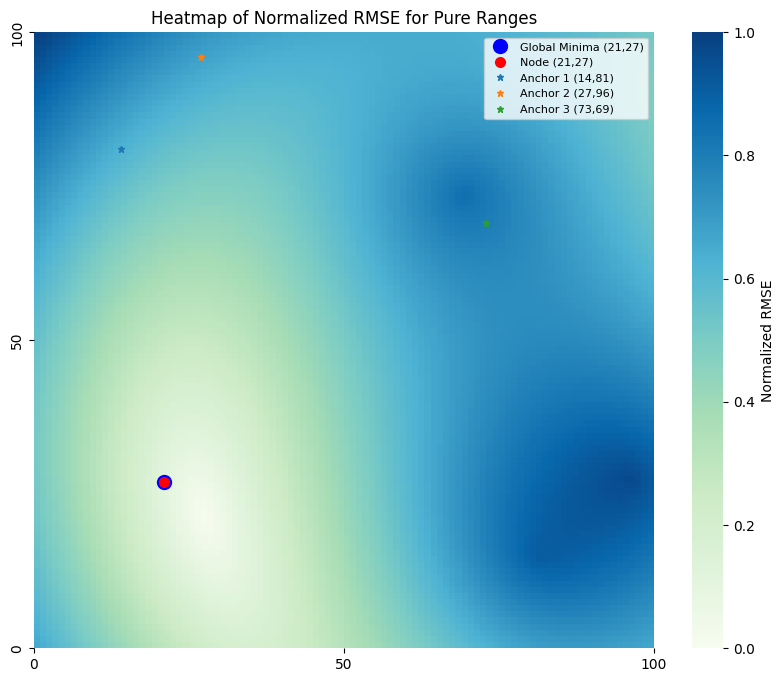

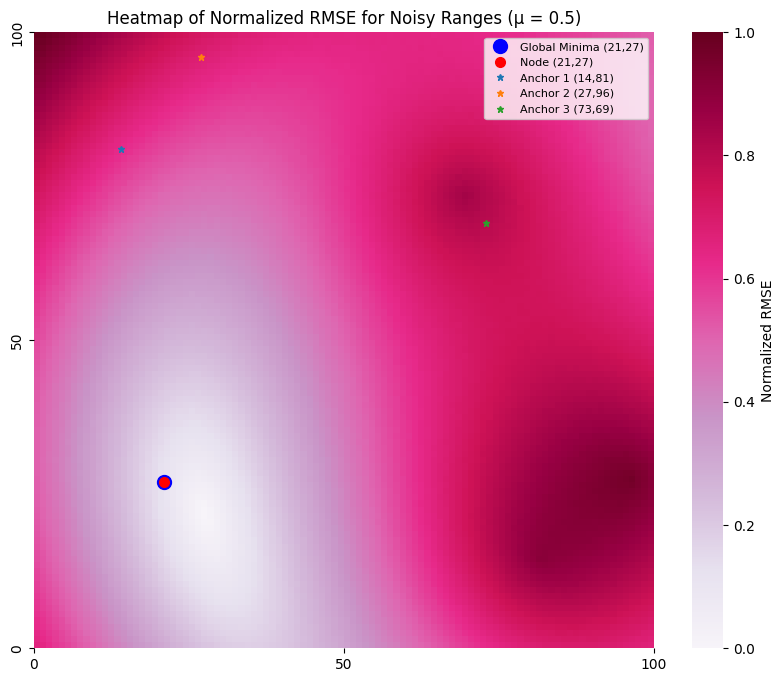

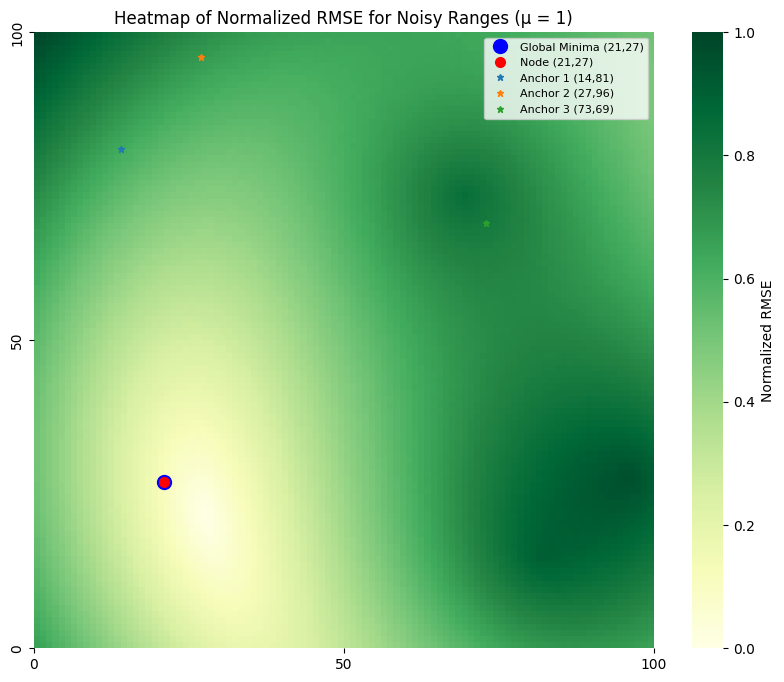

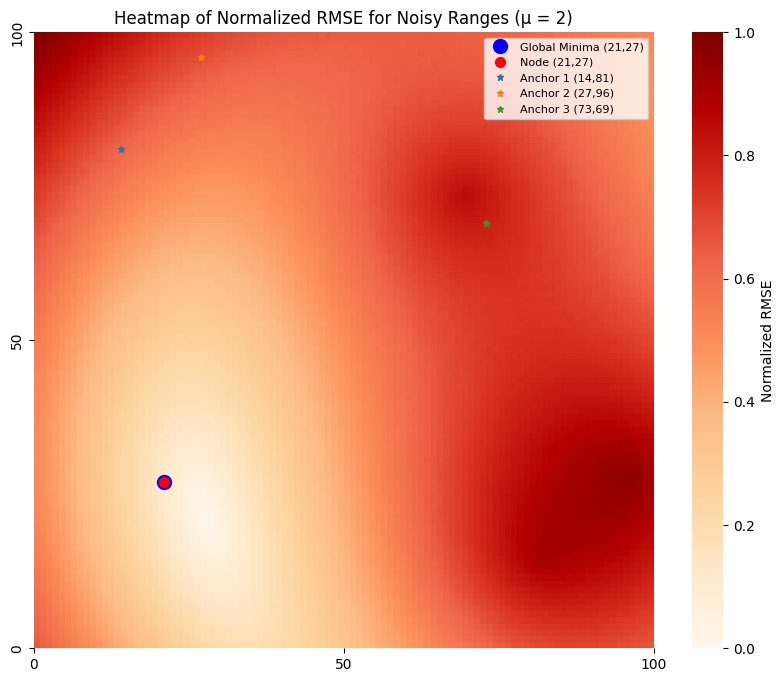

In [14]:
# Function to generate Gaussian noise with specified mean (mu) and standard deviation (sigma)
def gaussian_noise(mu, sigma):
    random_value = np.random.normal(mu, sigma)  # Generate random value based on normal distribution
    return random_value  # Return the generated noise value

# Function to compute the Euclidean distance between two points (coordinates) in 2D space.
def euclidean_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def add_noise(distance, mu, sigma):
    distance = distance + gaussian_noise(mu, sigma)
    return distance

# Function to calculate the Root Mean Square Error (RMSE) between a candidate location and the true ranges (distances) to the anchors.
def calculate_rmse(candidate, anchors, ranges, mu, sigma):
    # Calculate the estimated distances from the candidate location to each anchor.
    if mu == 0 and sigma == 0:
        estimated_distances = [euclidean_distance(candidate, anchor) for anchor in anchors]
    else:
        estimated_distances = [add_noise(euclidean_distance(candidate, anchor), mu, sigma) for anchor in anchors]
    # Compute the RMSE by comparing the estimated distances to the true range values.
    rmse = np.sqrt(np.mean([(estimated_distances[k] - ranges[k])**2 for k in range(3)]))
    return rmse

# Function to normalize a given matrix (to scale values between 0 and 1).
def normalize_matrix(matrix):
    # Find the minimum and maximum values in the matrix.
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    # Normalize the matrix by subtracting the minimum value and dividing by the range (max-min).
    return (matrix - min_val) / (max_val - min_val)

# Function to find the global minima in a given matrix.
def find_global_minima(matrix):
    min_value = float('inf')  # Initialize the minimum value to infinity.
    min_index = (-1, -1)  # Initialize the minimum index as (-1, -1), meaning no minima found yet.

    # Iterate through each element in the matrix.
    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            # Update the minimum value and index if a new lower value is found.
            if value < min_value:
                min_value = value
                min_index = (i, j)

    # Return the index and value of the global minima.
    return min_index, min_value

# Function to plot a heatmap of the given matrix values and highlight the global minima.
def plot_heatmap(value, min_index, title, color):
    plt.figure(figsize=(10, 8))  # Create a figure with specified size.
    # Create a heatmap using seaborn, with the specified color map, and labels for the color bar.
    sns.heatmap(value, cmap=color, alpha=1, cbar=True, cbar_kws={'label': 'Normalized RMSE'}, vmin=0, vmax=1)
    plt.title(title)  # Set the title of the heatmap.
    plt.gca().invert_yaxis()  # Invert the y-axis to match typical coordinate system conventions.
    plt.xticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set x-axis tick positions and labels.
    plt.yticks(ticks=[0, 50, 100], labels=['0', '50', '100'])  # Set y-axis tick positions and labels.
    # Plot the global minima on the heatmap as a blue dot.
    plt.plot(min_index[0], min_index[1], 'bo', markersize=10, label=f"Global Minima ({min_index[0]},{min_index[1]})")
    # Plot the actual node location as a red dot.
    plt.plot(node[0], node[1], 'ro', markersize=7, label=f"Node ({node[0]},{node[1]})")
    # Plot each anchor point as a star-shaped marker.
    for i, anchor in enumerate(anchors, start=1):
        plt.plot(anchor[0], anchor[1], '*', markersize=5, label=f"Anchor {i} ({anchor[0]},{anchor[1]})")
    plt.legend(fontsize=8)  # Add a legend to the plot with small font size.
    plt.show()  # Display the heatmap.

# Reading input CSV files into pandas DataFrames.
true_locations = pd.read_csv(true_locations_file_path, header=0)
pure_ranges = pd.read_csv(pure_ranges_file_path, header=0)
noisy_ranges_05 = pd.read_csv(noisy_ranges_05_file_path, header=0)
noisy_ranges_1 = pd.read_csv(noisy_ranges_1_file_path, header=0)
noisy_ranges_2 = pd.read_csv(noisy_ranges_2_file_path, header=0)

# Generate random indices A and B to select a row for anchors and a node location.
A = random.randint(1, 100)  # Random row index for anchor locations.
B = random.randint(1, 50)   # Random column index for node location (starts from 1, so adjusting later).
A = A - 1  # Adjust A to be zero-indexed.
B = B - 1 + 3  # Adjust B to select the correct node column after the anchor columns.

# Extract the anchor and node locations from the true locations data using the random indices.
anchors = [eval(true_locations.iloc[A, i]) for i in range(3)]  # Extract anchor coordinates.
print(f"Anchors Co-ordinates -> {anchors}")
node = eval(true_locations.iloc[A, B])  # Extract the node location.
print(f"Node Co-ordinates -> {node}")

# Retrieve the corresponding ranges for pure and noisy range datasets for the selected anchor-node pair.
pure_range = eval(pure_ranges.iloc[A, B])
noisy_range_05 = eval(noisy_ranges_05.iloc[A, B])
noisy_range_1 = eval(noisy_ranges_1.iloc[A, B])
noisy_range_2 = eval(noisy_ranges_2.iloc[A, B])

# Initialize cost matrices for pure and noisy ranges.
pure_ranges_cost_matrix = np.zeros((100, 100))
noisy_ranges_05_cost_matrix = np.zeros((100, 100))
noisy_ranges_1_cost_matrix = np.zeros((100, 100))
noisy_ranges_2_cost_matrix = np.zeros((100, 100))

# Compute the RMSE for every possible candidate location in the 100x100 grid.
for i in range(100):
    for j in range(100):
        candidate_location = (i, j)  # Define a candidate location in the grid.
        # Calculate the RMSE for each range set (pure and noisy) and store it in the respective cost matrices.
        pure_ranges_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, pure_range, mu=0, sigma=0)
        noisy_ranges_05_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, noisy_range_05, mu=0.5, sigma=0.1)
        noisy_ranges_1_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, noisy_range_1, mu=1, sigma=0.1)
        noisy_ranges_2_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, noisy_range_2, mu=2, sigma=0.1)

# Normalize the cost matrices (to scale RMSE values between 0 and 1).
pure_ranges_cost_matrix_normalized = normalize_matrix(pure_ranges_cost_matrix)
noisy_ranges_05_cost_matrix_normalized = normalize_matrix(noisy_ranges_05_cost_matrix)
noisy_ranges_1_cost_matrix_normalized = normalize_matrix(noisy_ranges_1_cost_matrix)
noisy_ranges_2_cost_matrix_normalized = normalize_matrix(noisy_ranges_2_cost_matrix)

# Find the global minima (location with the lowest RMSE) in each normalized cost matrix.
pure_ranges_minima_index, pure_ranges_minima_value = find_global_minima(pure_ranges_cost_matrix_normalized)
noisy_ranges_05_minima_index, noisy_ranges_05_minima_value = find_global_minima(noisy_ranges_05_cost_matrix_normalized)
noisy_ranges_1_minima_index, noisy_ranges_1_minima_value = find_global_minima(noisy_ranges_1_cost_matrix_normalized)
noisy_ranges_2_minima_index, noisy_ranges_2_minima_value = find_global_minima(noisy_ranges_2_cost_matrix_normalized)

# Print the coordinates of the global minima for each cost matrix.
print(f"Pure Ranges Minima Co-ordinates -> ({pure_ranges_minima_index[0]},{pure_ranges_minima_index[1]})")
print(f"Noisy Ranges 0.5 Minima Co-ordinates -> ({noisy_ranges_05_minima_index[0]},{noisy_ranges_05_minima_index[1]})")
print(f"Noisy Ranges 1 Minima Co-ordinates -> ({noisy_ranges_1_minima_index[0]},{noisy_ranges_1_minima_index[1]})")
print(f"Noisy Ranges 2 Minima Co-ordinates -> ({noisy_ranges_2_minima_index[0]},{noisy_ranges_2_minima_index[1]})")

# Plot heatmaps of the normalized RMSE for each of the cost matrices.
plot_heatmap(pure_ranges_cost_matrix_normalized, pure_ranges_minima_index, 'Heatmap of Normalized RMSE for Pure Ranges', "GnBu")
plot_heatmap(noisy_ranges_05_cost_matrix_normalized, noisy_ranges_05_minima_index, 'Heatmap of Normalized RMSE for Noisy Ranges (μ = 0.5)', "PuRd")
plot_heatmap(noisy_ranges_1_cost_matrix_normalized, noisy_ranges_1_minima_index, 'Heatmap of Normalized RMSE for Noisy Ranges (μ = 1)', "YlGn")
plot_heatmap(noisy_ranges_2_cost_matrix_normalized, noisy_ranges_2_minima_index, 'Heatmap of Normalized RMSE for Noisy Ranges (μ = 2)', "OrRd")


### Task 3: Trilateration. 

<div style="display:flex; overflow: hidden;">
  <div style="margin:20px;">
    <p>Now use an optimizer to solve for the node location for all 100x50 node locations (pure + 3 noisy versions). If you are using python, use lmfit (https://lmfit.github.io/lmfit-py/). Round off the output of the solver to the nearest integer value, say if the solver outputs (50.69, 45.23) - round it off to (51, 45) for the estimated location cell. Also make sure the solver knows the limits of the solution (i.e., the bounding box). Write the solvers output into 4 files, &lt;pure_locs.csv&gt;, &lt;noisy_locs_05.csv&gt;, &lt;noisy_locs_1.csv&gt; and &lt;noisy_locs_2.csv&gt;. Compare the solved locations with the entries in &lt;true_locations.csv&gt; and compute the localization errors (euclidean distance between true and estimated location).
    </p>
    <p></p>
    <p>a. Plot 4 CDFs (each for the 5000 error values) on the same graph, to compare the 4 cases.
    <p>
For the 4 cases state the: 
</p><p>
(i) median error, </p><p>
(ii) 75th percentile error,</p><p>
(iii) 95th percentile error.
    </p>
  </div>
</div>



### Summary of Code Functions:

1. **Euclidean Distance Calculation:**
   - **`euclidean_distance(x1, y1, x2, y2)`**: This function computes the Euclidean distance between two points `(x1, y1)` and `(x2, y2)` using the standard formula:
     distance = {(x2 - x1)^2 + (y2 - y1)^2}^(1/2)

2. **Objective Function for Optimization:**
   - **`objective_function(params, anchors, ranges)`**: This function calculates the residuals (errors) between predicted and actual distances for each anchor-node pair. The predicted ranges are computed based on the Euclidean distance between the node and the anchors. The goal is to minimize the residuals to estimate the node location optimally.

3. **Solving Node Location:**
   - **`solve_node_location(anchors, ranges)`**: This function estimates the node's location by minimizing the objective function using a non-linear optimization algorithm (`lmfit.minimize`). It starts with an initial guess based on the average coordinates of the anchors and adjusts the node's location to minimize the distance between predicted and actual ranges.

4. **Reading Range and Anchor Data from CSV:**
   - **`read_ranges_from_csv(file_path)`**: This function reads a CSV file containing anchors and ranges. It extracts the relevant columns (for 3 anchors and 50 nodes) and returns them as lists of tuples.

5. **Solving for All Node Locations:**
   - **`solve_for_all_nodes(data)`**: This function iterates over all the data (sets of anchors and ranges) and solves for the location of each node using the `solve_node_location` function.

6. **Creating Anchor-Node Pairs:**
   - **`create_anchor_node_pairs(all_anchors, all_nodes)`**: This function creates pairs of anchors and their corresponding solved node locations. It returns a list of dictionaries, where each dictionary contains a set of anchors and its corresponding solved node locations.

7. **Writing Solved Locations to CSV:**
   - **`write_solved_locations_to_csv(solved_locations_data, file_path)`**: This function writes the solved node locations, along with their corresponding anchors, into a CSV file. The CSV file is structured with columns for anchor coordinates and node coordinates.

8. **Rounding Node Coordinates to Integers:**
   - **`round_node_coordinates_to_int(nodes)`**: This function rounds the coordinates of nodes to the nearest integers. It returns the rounded node coordinates.

9. **Reading Node Locations from CSV:**
   - **`read_node_locations(file_path)`**: This function reads the node locations from a CSV file. It assumes the node coordinates start from the 4th column and returns a list of node location tuples.

10. **Calculating Localization Error:**
    - **`calculate_localization_error(true_nodes, predicted_nodes)`**: This function calculates the localization error (Euclidean distance) between the true node locations and the predicted node locations.

11. **Creating Anchor-Node Error Pairs:**
    - **`create_anchor_node_error_pairs(all_anchors, all_nodes)`**: This function creates pairs of anchors and their corresponding node errors. It returns a list of dictionaries, where each dictionary contains a set of anchors and its corresponding node errors.

12. **Flattening Error Data:**
    - **`flatten_errors(error_data)`**: This function flattens a list of error lists (for different node sets) into a single list of errors, making it easier to analyze the overall distribution of errors.

13. **Calculating Percentiles of Errors:**
    - **`calculate_percentiles(errors)`**: This function calculates the median, 75th percentile, and 95th percentile of the error distribution. These percentiles provide insights into the typical, upper-middle, and extreme errors in the data.

14. **Reading Data:**
    - The code starts by reading range and anchor data from CSV files for four datasets: pure ranges and noisy ranges with different noise levels (0.5, 1.0, 2.0).

15. **Solving Node Locations:**
    - For each dataset (pure and noisy ranges), the node locations are solved using the provided range data and anchor positions.

16. **Creating Anchor-Node Pairs:**
    - Anchor-node pairs are created, associating each anchor with its solved node positions for each dataset.

17. **Rounding Node Coordinates:**
    - The solved node coordinates are rounded to the nearest integer to match realistic positioning scenarios.

18. **Creating Anchor-Node Pairs for Rounded Locations:**
    - New anchor-node pairs are created for the rounded node locations, which are useful for analysis where discrete coordinates are required.

19. **File Paths:**
    - The first block defines file paths for storing the solved and rounded node locations for different datasets: pure ranges and noisy ranges with different noise levels (0.5, 1.0, 2.0).

20. **Saving Solved Locations to CSV:**
    - The next lines use the function `write_solved_locations_to_csv` to save the rounded solved node locations for each dataset into respective CSV files.

21. **Reading True Node Locations:**
    - The true node locations are read from a file using `read_node_locations`.

22. **Reading Solved Node Locations and Calculating Errors:**
    - The rounded solved node locations for the pure and noisy ranges datasets are read from their respective CSV files. Then, the localization error (Euclidean distance between true and predicted node locations) is calculated using the `calculate_localization_error` function for each dataset.

23. **Creating Anchor-Node Error Pairs:**
    - Finally, for each dataset (pure and noisy ranges), anchor-node error pairs are created using the `create_anchor_node_error_pairs` function. This step helps associate each anchor with its respective localization error.

24. **Flattening Errors:**
    - The errors for each dataset (pure and noisy ranges with different noise levels) are flattened into 1D lists for easier processing.

25. **CDF Plotting:**
    - The flattened error lists are sorted, and their cumulative distribution is calculated.
    - The CDF for each error distribution is plotted, and the variance of the cumulative distribution is calculated and stored.
    - The plot shows the cumulative distribution of localization errors for different datasets.

26. **Percentile Calculation:**
    - The median, 75th percentile, and 95th percentile are calculated for the errors in each dataset.

27. **Dataframe Creation and Display:**
    - A dictionary is created to store the error type and their corresponding percentiles.
    - A `pandas` DataFrame is created from this dictionary.
    - The `tabulate` function is used to print the DataFrame in a grid format, showing the error statistics for each dataset.

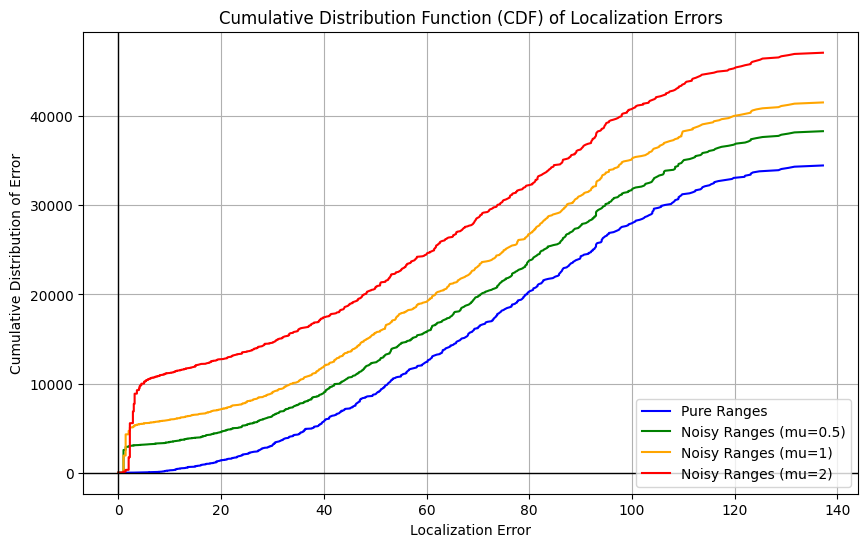

+-----------------------+----------------+-------------------------+-------------------------+
| Error Type            |   Median Error |   75th Percentile Error |   95th Percentile Error |
+=======================+================+=========================+=========================+
| Pure Ranges           |        0       |                 0       |                 61      |
+-----------------------+----------------+-------------------------+-------------------------+
| Noisy Ranges (mu=0.5) |        1       |                 1       |                 61.7171 |
+-----------------------+----------------+-------------------------+-------------------------+
| Noisy Ranges (mu=1)   |        1.41421 |                 1.41421 |                 61.2699 |
+-----------------------+----------------+-------------------------+-------------------------+
| Noisy Ranges (mu=2)   |        2.23607 |                 3.16228 |                 61.8466 |
+-----------------------+----------------+--------

In [ ]:
def euclidean_distance(x1, y1, x2, y2):
    # This function calculates the Euclidean distance between two points (x1, y1) and (x2, y2)
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def objective_function(params, anchors, ranges):
    # This function calculates the residuals between predicted and actual ranges for optimization
    x_node = params['x_node']  # Extract the x-coordinate of the node from the params
    y_node = params['y_node']  # Extract the y-coordinate of the node from the params
    predicted_ranges = []  # List to store predicted ranges for each anchor
    
    for anchor in anchors:
        # For each anchor, calculate the Euclidean distance from the node to the anchor
        predicted_range = euclidean_distance(x_node, y_node, anchor[0], anchor[1])
        predicted_ranges.append(predicted_range)  # Store the predicted range
    
    # Calculate residuals: difference between predicted range and actual range for each anchor
    residuals = [predicted_ranges[i] - ranges[i] for i in range(3)]
    return residuals  # Return the residuals to be minimized

def solve_node_location(anchors, ranges):
    # This function estimates the node's location using optimization to minimize the objective function
    initial_guess = {
        'x_node': sum([a[0] for a in anchors]) / len(anchors),  # Average x-coordinate of the anchors
        'y_node': sum([a[1] for a in anchors]) / len(anchors)   # Average y-coordinate of the anchors
    }
    
    params = lmfit.Parameters()  # Create an lmfit.Parameters object to hold the node parameters
    params.add('x_node', value=initial_guess['x_node'], min=0, max=100)  # Set initial guess and boundaries for x
    params.add('y_node', value=initial_guess['y_node'], min=0, max=100)  # Set initial guess and boundaries for y
    
    # Minimize the objective function to find the best estimate for the node's location
    result = lmfit.minimize(objective_function, params, args=(anchors, ranges))
    
    # Extract the optimized x and y coordinates for the node
    x_node_est = float(result.params['x_node'].value)
    y_node_est = float(result.params['y_node'].value)
    
    return x_node_est, y_node_est  # Return the estimated node coordinates

def read_ranges_from_csv(file_path):
    # This function reads range and anchor data from a CSV file and returns it
    data = []  # List to store all the data
    with open(file_path, mode='r') as infile:
        reader = csv.reader(infile)  # Create a CSV reader
        header = next(reader)  # Skip the header row
        all_anchors = []  # List to store all anchors
        all_ranges = []  # List to store all ranges
        
        # Find the column indices for anchors and node ranges in the header
        anchor_indices = [header.index(f"Anchor_{i+1}") for i in range(3)]
        range_indices = [header.index(f"Node_{i+1}") for i in range(50)]
        
        for row in reader:
            # For each row, extract anchor coordinates and range values
            anchors = [tuple(map(int, row[anchor_indices[i]].strip('()').split(', '))) for i in range(3)]
            ranges = [tuple(map(float, row[range_indices[i]].strip('()').split(', '))) for i in range(50)]
            data.append((anchors, ranges))  # Append the data to the list
            all_anchors.append(anchors)  # Store the anchors
            all_ranges.append(ranges)  # Store the ranges
    
    return data, all_anchors, all_ranges  # Return the parsed data

def solve_for_all_nodes(data):
    # This function solves for all node locations in the provided data
    solved_nodes = []  # List to store solved node locations
    
    for anchors, ranges in data:
        node_locations = []  # List to store node locations for this set of ranges
        
        for range_value in ranges:
            # Solve for each node location using the given anchors and range value
            x_node, y_node = solve_node_location(anchors, range_value)
            node_locations.append((x_node, y_node))  # Append the solved node location
        
        solved_nodes.append(node_locations)  # Append the solved locations for this dataset
    
    return solved_nodes  # Return all solved node locations

def create_anchor_node_pairs(all_anchors, all_nodes):
    # This function creates pairs of anchors and nodes in a dictionary format
    solved = []  # List to store the anchor-node pairs
    for anchors, nodes in zip(all_anchors, all_nodes):
        solved.append({"Anchor Set": anchors, "Node Set": nodes})  # Create a dictionary for each pair
    
    return solved  # Return the list of anchor-node pairs

def write_solved_locations_to_csv(solved_locations_data, file_path):
    # This function writes the solved locations to a CSV file
    if os.path.exists(file_path):
        os.remove(file_path)  # Remove the file if it already exists
    
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)  # Create a CSV writer
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{j+1}" for j in range(50)]  # Create a header row
        writer.writerow(header)  # Write the header to the CSV file
        
        for idx, data in enumerate(solved_locations_data):
            # For each solved location, write the anchor and node coordinates to the file
            row = [f"({x}, {y})" for (x, y) in data["Anchor Set"]] + \
                  [f"({x}, {y})" for (x, y) in data["Node Set"]]
            writer.writerow(row)  # Write the row to the CSV file

def round_node_coordinates_to_int(nodes):
    # This function rounds node coordinates to the nearest integer
    return [(round(x), round(y)) for x, y in nodes]

def read_node_locations(file_path):
    # This function reads node locations from a CSV file
    node_locations = []  # List to store node locations
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)  # Create a CSV reader
        next(reader)  # Skip the header row
        for row in reader:
            # For each row, extract node locations starting from the 4th column
            nodes = [tuple(map(int, val.strip("()").split(', '))) for val in row[3:]]
            node_locations.append(nodes)  # Append the nodes to the list
    
    return node_locations  # Return the list of node locations

def calculate_localization_error(true_nodes, predicted_nodes):
    # This function calculates the localization error between true and predicted node locations
    errors = []  # List to store error values
    for true_set, pred_set in zip(true_nodes, predicted_nodes):
        # Calculate the error for each pair of true and predicted nodes
        set_errors = [euclidean_distance(t[0], t[1], p[0], p[1]) for t, p in zip(true_set, pred_set)]
        errors.append(set_errors)  # Append the errors for this set of nodes
    
    return errors  # Return the list of errors for all node sets

def create_anchor_node_error_pairs(all_anchors, all_nodes):
    # This function creates pairs of anchors and their corresponding node errors
    solved = []  # List to store anchor-node error pairs
    for anchors, nodes in zip(all_anchors, all_nodes):
        solved.append({"Anchor Set": anchors, "Node Error": nodes})  # Create a dictionary for each pair
    
    return solved  # Return the list of anchor-node error pairs

def flatten_errors(error_data):
    # This function flattens a list of errors into a single list
    return [error for node_errors in error_data for error in node_errors]

def calculate_percentiles(errors):
    # This function calculates the median, 75th percentile, and 95th percentile of errors
    errors_sorted = sorted(errors)  # Sort the errors
    median = statistics.median(errors_sorted)  # Calculate the median of the errors
    p75_index = int(0.75 * len(errors_sorted))  # Calculate the index for the 75th percentile
    p75 = errors_sorted[p75_index]  # Get the 75th percentile value
    p95_index = int(0.95 * len(errors_sorted))  # Calculate the index for the 95th percentile
    p95 = errors_sorted[p95_index]  # Get the 95th percentile value
    
    return median, p75, p95  # Return the calculated percentiles

# Reading range and anchor data from CSV files using the function `read_ranges_from_csv`
# Reads data for pure ranges from a CSV file and unpacks the results into: pure_ranges_data, pure_ranges_anchor, pure_ranges
pure_ranges_data, pure_ranges_anchor, pure_ranges = read_ranges_from_csv(pure_ranges_file_path)
# Reads data for noisy ranges with 0.5 noise level from a CSV file and unpacks the results into: noisy_ranges_05_data, noisy_ranges_05_anchors, noisy_ranges_05
noisy_ranges_05_data, noisy_ranges_05_anchors, noisy_ranges_05 = read_ranges_from_csv(noisy_ranges_05_file_path)
# Reads data for noisy ranges with 1.0 noise level from a CSV file and unpacks the results into: noisy_ranges_1_data, noisy_ranges_1_anchors, noisy_ranges_1
noisy_ranges_1_data, noisy_ranges_1_anchors, noisy_ranges_1 = read_ranges_from_csv(noisy_ranges_1_file_path)
# Reads data for noisy ranges with 2.0 noise level from a CSV file and unpacks the results into: noisy_ranges_2_data, noisy_ranges_2_anchors, noisy_ranges_2
noisy_ranges_2_data, noisy_ranges_2_anchors, noisy_ranges_2 = read_ranges_from_csv(noisy_ranges_2_file_path)

# Solving node locations using the range data for pure and noisy cases by invoking `solve_for_all_nodes`
# Solves for the node locations for the pure ranges dataset, returning the node positions
pure_nodes = solve_for_all_nodes(pure_ranges_data)
# Solves for the node locations for the noisy ranges with 0.5 noise level dataset
noisy_nodes_05 = solve_for_all_nodes(noisy_ranges_05_data)
# Solves for the node locations for the noisy ranges with 1.0 noise level dataset
noisy_nodes_1 = solve_for_all_nodes(noisy_ranges_1_data)
# Solves for the node locations for the noisy ranges with 2.0 noise level dataset
noisy_nodes_2 = solve_for_all_nodes(noisy_ranges_2_data)

# Creating anchor-node pairs for pure and noisy ranges, using the `create_anchor_node_pairs` function
# Creates a dictionary of anchor-node pairs for pure ranges (anchors and their corresponding solved node locations)
pure_ranges_solved = create_anchor_node_pairs(pure_ranges_anchor, pure_nodes)
# Creates a dictionary of anchor-node pairs for noisy ranges with 0.5 noise level
noisy_ranges_05_solved = create_anchor_node_pairs(noisy_ranges_05_anchors, noisy_nodes_05)
# Creates a dictionary of anchor-node pairs for noisy ranges with 1.0 noise level
noisy_ranges_1_solved = create_anchor_node_pairs(noisy_ranges_1_anchors, noisy_nodes_1)
# Creates a dictionary of anchor-node pairs for noisy ranges with 2.0 noise level
noisy_ranges_2_solved = create_anchor_node_pairs(noisy_ranges_2_anchors, noisy_nodes_2)

# Rounding the node coordinates to integer values using `round_node_coordinates_to_int`
# Rounds the solved node coordinates for pure ranges to the nearest integer
pure_nodes_rounded = [round_node_coordinates_to_int(nodes) for nodes in pure_nodes]
# Rounds the solved node coordinates for noisy ranges with 0.5 noise level to the nearest integer
noisy_nodes_05_rounded = [round_node_coordinates_to_int(nodes) for nodes in noisy_nodes_05]
# Rounds the solved node coordinates for noisy ranges with 1.0 noise level to the nearest integer
noisy_nodes_1_rounded = [round_node_coordinates_to_int(nodes) for nodes in noisy_nodes_1]
# Rounds the solved node coordinates for noisy ranges with 2.0 noise level to the nearest integer
noisy_nodes_2_rounded = [round_node_coordinates_to_int(nodes) for nodes in noisy_nodes_2]

# Creating anchor-node pairs for the rounded node coordinates
# Creates a dictionary of anchor-node pairs for pure ranges, with the rounded node locations
pure_ranges_solved_rounded = create_anchor_node_pairs(pure_ranges_anchor, pure_nodes_rounded)
# Creates a dictionary of anchor-node pairs for noisy ranges with 0.5 noise level, with the rounded node locations
noisy_ranges_05_solved_rounded = create_anchor_node_pairs(noisy_ranges_05_anchors, noisy_nodes_05_rounded)
# Creates a dictionary of anchor-node pairs for noisy ranges with 1.0 noise level, with the rounded node locations
noisy_ranges_1_solved_rounded = create_anchor_node_pairs(noisy_ranges_1_anchors, noisy_nodes_1_rounded)
# Creates a dictionary of anchor-node pairs for noisy ranges with 2.0 noise level, with the rounded node locations
noisy_ranges_2_solved_rounded = create_anchor_node_pairs(noisy_ranges_2_anchors, noisy_nodes_2_rounded)

# File paths where the rounded node locations will be saved as CSV files
# This file path stores the rounded solved node locations for the pure ranges dataset
pure_ranges_solved_rounded_locations_file_path = 'dipendu_data/pure_locs.csv'
# This file path stores the rounded solved node locations for the noisy ranges with 0.5 noise level
noisy_ranges_05_solved_rounded_locations_file_path = 'dipendu_data/noisy_locs_05.csv'
# This file path stores the rounded solved node locations for the noisy ranges with 1.0 noise level
noisy_ranges_1_solved_rounded_locations_file_path = 'dipendu_data/noisy_locs_1.csv'
# This file path stores the rounded solved node locations for the noisy ranges with 2.0 noise level
noisy_ranges_2_solved_rounded_locations_file_path = 'dipendu_data/noisy_locs_2.csv'

# Writing the solved rounded node locations to respective CSV files
# Saves the rounded solved node locations for the pure ranges dataset to the specified file path
write_solved_locations_to_csv(pure_ranges_solved_rounded, pure_ranges_solved_rounded_locations_file_path)
# Saves the rounded solved node locations for the noisy ranges with 0.5 noise level to the specified file path
write_solved_locations_to_csv(noisy_ranges_05_solved_rounded, noisy_ranges_05_solved_rounded_locations_file_path)
# Saves the rounded solved node locations for the noisy ranges with 1.0 noise level to the specified file path
write_solved_locations_to_csv(noisy_ranges_1_solved_rounded, noisy_ranges_1_solved_rounded_locations_file_path)
# Saves the rounded solved node locations for the noisy ranges with 2.0 noise level to the specified file path
write_solved_locations_to_csv(noisy_ranges_2_solved_rounded, noisy_ranges_2_solved_rounded_locations_file_path)

# Reads the true node locations from the `true_locations_file_path` and stores them as `true_nodes`
true_nodes = read_node_locations(true_locations_file_path)

# Reads the rounded solved node locations for the pure ranges dataset from the CSV file
pure_ranges_solved_nodes = read_node_locations(pure_ranges_solved_rounded_locations_file_path)

# Calculates the localization error between true node locations and the predicted locations from the pure ranges dataset
pure_ranges_solved_errors = calculate_localization_error(true_nodes, pure_ranges_solved_nodes)
# Reads the rounded solved node locations for noisy ranges with 0.5 noise level from the CSV file
noisy_ranges_05_solved_nodes = read_node_locations(noisy_ranges_05_solved_rounded_locations_file_path)
# Calculates the localization error between true node locations and the predicted locations from the noisy ranges with 0.5 noise level
noisy_ranges_05_solved_errors = calculate_localization_error(true_nodes, noisy_ranges_05_solved_nodes)
# Reads the rounded solved node locations for noisy ranges with 1.0 noise level from the CSV file
noisy_ranges_1_solved_nodes = read_node_locations(noisy_ranges_1_solved_rounded_locations_file_path)
# Calculates the localization error between true node locations and the predicted locations from the noisy ranges with 1.0 noise level
noisy_ranges_1_solved_errors = calculate_localization_error(true_nodes, noisy_ranges_1_solved_nodes)
# Reads the rounded solved node locations for noisy ranges with 2.0 noise level from the CSV file
noisy_ranges_2_solved_nodes = read_node_locations(noisy_ranges_2_solved_rounded_locations_file_path)
# Calculates the localization error between true node locations and the predicted locations from the noisy ranges with 2.0 noise level
noisy_ranges_2_solved_errors = calculate_localization_error(true_nodes, noisy_ranges_2_solved_nodes)

# Creating anchor-node error pairs for the pure ranges dataset
pure_ranges_error = create_anchor_node_error_pairs(pure_ranges_anchor, pure_ranges_solved_errors)
# Creating anchor-node error pairs for the noisy ranges with 0.5 noise level dataset
noisy_ranges_05_error = create_anchor_node_error_pairs(noisy_ranges_05_anchors, noisy_ranges_05_solved_errors)
# Creating anchor-node error pairs for the noisy ranges with 1.0 noise level dataset
noisy_ranges_1_error = create_anchor_node_error_pairs(noisy_ranges_1_anchors, noisy_ranges_1_solved_errors)
# Creating anchor-node error pairs for the noisy ranges with 2.0 noise level dataset
noisy_ranges_2_error = create_anchor_node_error_pairs(noisy_ranges_2_anchors, noisy_ranges_2_solved_errors)

# Flattening the list of localization errors for the pure ranges dataset
pure_errors_flat = flatten_errors(pure_ranges_solved_errors)
# Flattening the list of localization errors for the noisy ranges dataset with 0.5 noise level
noisy_05_errors_flat = flatten_errors(noisy_ranges_05_solved_errors)
# Flattening the list of localization errors for the noisy ranges dataset with 1.0 noise level
noisy_1_errors_flat = flatten_errors(noisy_ranges_1_solved_errors)
# Flattening the list of localization errors for the noisy ranges dataset with 2.0 noise level
noisy_2_errors_flat = flatten_errors(noisy_ranges_2_solved_errors)

# Collecting all the flattened error lists into one list for easy iteration
errors_list = [pure_errors_flat, noisy_05_errors_flat, noisy_1_errors_flat, noisy_2_errors_flat]

# Labels for the different error distributions, which will be used for plotting the CDFs
labels = ['Pure Ranges', 'Noisy Ranges (mu=0.5)', 'Noisy Ranges (mu=1)', 'Noisy Ranges (mu=2)']

# Colors for the different error distributions in the plot
colors = ['blue', 'green', 'orange', 'red']

# List to store the variances of the cumulative distribution functions (CDFs) for each error distribution
cdf_variances = []

# Creating a plot for the cumulative distribution function (CDF) of the localization errors
plt.figure(figsize=(10, 6))

# Iterating through the error distributions, their labels, and their colors
for i, (errors, label, color) in enumerate(zip(errors_list, labels, colors)):
    # Sorting the error list in ascending order to calculate the CDF
    sorted_errors = np.sort(errors)
    # Cumulative sum of sorted errors to get the cumulative distribution
    cumulative_distribution = np.cumsum(sorted_errors)
    # Calculate the variance of the errors in the current error distribution
    variance = np.var(errors)
    # Calculate the variance of the cumulative distribution, which is the variance of the CDF
    cdf_variance = np.var(cumulative_distribution)
    # Append the variance of the CDF to the list of variances
    cdf_variances.append(cdf_variance)
    # Plot the CDF for the current error distribution
    plt.plot(sorted_errors, cumulative_distribution, label=f'{label}', color=color)

# Labeling the x-axis as 'Localization Error'
plt.xlabel('Localization Error')

# Labeling the y-axis as 'Cumulative Distribution of Error'
plt.ylabel('Cumulative Distribution of Error')

# Adding a title to the plot
plt.title('Cumulative Distribution Function (CDF) of Localization Errors')

# Adding a legend to the plot, located at the lower right corner
plt.legend(loc='lower right')

# Adding horizontal and vertical lines at 0 for reference
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)

# Adding a grid to the plot for better readability
plt.grid()

# Displaying the plot
plt.show()

# Calculating the median, 75th percentile, and 95th percentile of errors for the pure ranges dataset
pure_median, pure_p75, pure_p95 = calculate_percentiles(pure_errors_flat)
# Calculating the median, 75th percentile, and 95th percentile of errors for the noisy ranges dataset with 0.5 noise level
noisy_05_median, noisy_05_p75, noisy_05_p95 = calculate_percentiles(noisy_05_errors_flat)
# Calculating the median, 75th percentile, and 95th percentile of errors for the noisy ranges dataset with 1.0 noise level
noisy_1_median, noisy_1_p75, noisy_1_p95 = calculate_percentiles(noisy_1_errors_flat)
# Calculating the median, 75th percentile, and 95th percentile of errors for the noisy ranges dataset with 2.0 noise level
noisy_2_median, noisy_2_p75, noisy_2_p95 = calculate_percentiles(noisy_2_errors_flat)

# Creating a dictionary to store the error type and their corresponding percentiles
data = {
    'Error Type': ['Pure Ranges', 'Noisy Ranges (mu=0.5)', 'Noisy Ranges (mu=1)', 'Noisy Ranges (mu=2)'],
    # Error types for each dataset
    'Median Error': [pure_median, noisy_05_median, noisy_1_median, noisy_2_median],
    # Median localization errors for each dataset
    '75th Percentile Error': [pure_p75, noisy_05_p75, noisy_1_p75, noisy_2_p75],
    # 75th percentile localization errors for each dataset
    '95th Percentile Error': [pure_p95, noisy_05_p95, noisy_1_p95, noisy_2_p95]
    # 95th percentile localization errors for each dataset
}

# Creating a DataFrame from the dictionary to represent the data in a tabular format
error_df = pd.DataFrame(data)

# Printing the DataFrame in a grid format using the `tabulate` library
print(tabulate(error_df, headers="keys", tablefmt="grid", showindex=False))
